# Импорты

In [1]:
# %pip install datasets
# %pip install gensim
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np

from tqdm import tqdm

from datasets import Dataset, DatasetDict
from nltk import word_tokenize
from torchtext import vocab
from torch import nn
import torch

###

from gensim.models import KeyedVectors
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

import torch.optim as optim


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\Elena\Desktop\лш 2024\practice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Elena\Desktop\лш 2024\practice\.venv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Elena\Desktop\лш 2024\practice\.venv\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT T

In [2]:
dfs = {}
dfs['train'] = pd.read_csv('train_data.csv')
dfs['val'] = pd.read_csv('validation_data.csv')

# Создадим датасет

Будем использовать классы из библиотеки datasets. Хорошая новость -- так работают с датасетами и сейчас, в том числе с SOTA моделями. Переучиваться не нужно!

Дока к либе: https://huggingface.co/docs/datasets/index;\n

Обращаться к фичам можно как `Dataset[feature_name]`

In [3]:
def get_dataset(df):
    tokens = df['comment'].apply(lambda x: word_tokenize(x))
    return Dataset.from_dict({'tokens': tokens, 'labels': df['toxic']})

DatasetDict нужен, чтобы держать вместе и трейн, и тест, и валидацию (называем их сплитами). Фактически, это словарь.

In [4]:
data = DatasetDict()
splits = ['train', 'val']

for s in splits:
    data[s] = get_dataset(dfs[s])

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 11525
    })
    val: Dataset({
        features: ['tokens', 'labels'],
        num_rows: 2882
    })
})

# Создаем себе словарь токенов по w2v модели

In [6]:
fasttext_path = 'toxic_model.bin'

w2v = KeyedVectors.load('toxic_model')

print(f"Number of words in FastText model: {len(w2v.key_to_index)}")
print(f"Embedding dimension: {w2v.vector_size}")

Number of words in FastText model: 51494
Embedding dimension: 300


In [7]:
print(w2v['привет'].shape)
print(type(w2v['привет']))
pad_vec = np.zeros((300,))
print(pad_vec.shape)
PAD_TOK = "<pad>"
w2v.add_vector(PAD_TOK, pad_vec)

(300,)
<class 'numpy.ndarray'>
(300,)


c:\Users\Elena\Desktop\лш 2024\practice\.venv\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


51494

In [8]:
# строим словарь по словам из w2v
vocabulary = vocab.build_vocab_from_iterator([w2v.index_to_key], specials=['<pad>'])
len(vocabulary)

51495

In [9]:
vocabulary.vocab.get_itos()[10000:10030]

['диода',
 'диодными',
 'диодов',
 'диоксид',
 'диоксин',
 'диоптрий',
 'диоптриях',
 'дип',
 'диплом',
 'диплома',
 'дипломами',
 'дипломатии',
 'дипломатической',
 'дипломированными',
 'дипломные',
 'дипломом',
 'дипломы',
 'дипольный',
 'директор',
 'директора',
 'директорией',
 'директории',
 'директоров',
 'директором',
 'директору',
 'дирижабля',
 'диск',
 'диска',
 'дискам',
 'дисками']

In [10]:
stoi = vocabulary.vocab.get_stoi()
stoi

{'фотошопит': 48464,
 '3д': 236,
 'безлимит': 2885,
 'фотосессии': 48453,
 '-летним': 39,
 'кумовья': 18583,
 'клейму': 16598,
 'кой': 16853,
 'аппаратуру': 2131,
 'проспекта': 35727,
 'бама': 2614,
 'определены': 26325,
 'реалии': 37901,
 '500руб': 280,
 'сарафанное': 39363,
 'york': 1219,
 'ppo': 935,
 'мебель': 20430,
 'пуки': 36280,
 'забросают': 12187,
 '<pad>': 0,
 'внутренний': 5586,
 'сот': 42176,
 'автомойке': 1404,
 'рогатых': 38592,
 'd50': 474,
 'half': 626,
 'первым': 28685,
 'изрыгая': 14701,
 '-ым': 59,
 'выживающих': 6898,
 'epson': 541,
 'волшебных': 5954,
 'горячий': 8528,
 'косячат': 17900,
 'аулы': 2399,
 'лобовое': 19424,
 'стильную': 43261,
 'провозглашение': 35025,
 'запрессованы': 13338,
 'антифриза': 2078,
 'пограничники': 30386,
 '-ми': 44,
 'быстро': 4215,
 'комфорта': 17278,
 'жильцам': 11949,
 'сорванных': 42026,
 'джуна': 9862,
 'all': 371,
 'амишей': 1889,
 'неподходящее': 23936,
 'вставок': 6427,
 'законны': 12776,
 'жительства': 11983,
 '3к': 238,
 'гом

In [11]:
print(f"Оригинал: {data['train']['tokens'][0]}")
example_ids = vocabulary.forward(data['train']['tokens'][0])
print(f"ID токенов: {example_ids}")
print(f"Обратно отбразили из ID токенов: {vocabulary.lookup_tokens(example_ids)}")

Оригинал: ['тут', 'проблема', '-', 'где', 'критерии', 'и', 'границы', '?', 'кто-то', 'также', 'перечитает', 'и', 'пойдёт', 'тоже', 'решать', 'и', 'так', 'др', 'за', 'другом', ',', 'в', 'какой-то', 'момент', 'может', 'оказаться', ',', 'что', 'уже', 'всё', 'совсем', 'рядом', 'горит']
ID токенов: [45999, 34872, 5, 7805, 18248, 14296, 8710, 348, 18484, 44318, 29255, 14296, 31381, 45106, 38446, 14296, 44312, 10947, 12074, 11048, 4, 4276, 15780, 21442, 21336, 25921, 4, 49953, 46707, 6516, 41661, 39105, 8454]
Обратно отбразили из ID токенов: ['тут', 'проблема', '-', 'где', 'критерии', 'и', 'границы', '?', 'кто-то', 'также', 'перечитает', 'и', 'пойдёт', 'тоже', 'решать', 'и', 'так', 'др', 'за', 'другом', ',', 'в', 'какой-то', 'момент', 'может', 'оказаться', ',', 'что', 'уже', 'всё', 'совсем', 'рядом', 'горит']


In [12]:
# традиционная сигнатура функции, которая применяется к экземпляру класса датасет
def numericalize_data(example):
    token_idxs = vocabulary.forward([t for t in example['tokens'] if t in vocabulary])
    return {'token_idxs': token_idxs}

In [13]:
ids_data = data.map(numericalize_data, remove_columns=['tokens']).with_format(type='torch')

Map: 100%|██████████| 2882/2882 [00:00<00:00, 3000.04 examples/s]


In [14]:
ids_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'token_idxs'],
        num_rows: 11525
    })
    val: Dataset({
        features: ['labels', 'token_idxs'],
        num_rows: 2882
    })
})

# Инициализируем эмбеддинги w2v

In [15]:


def initialize_embedding(vocab, keyed_vectors, padding_token="<pad>"):
    """
    Initializes a PyTorch nn.Embedding layer with pre-trained embeddings.

    Args:
        vocab (list of str): List of words in the vocabulary.
        keyed_vectors (KeyedVectors): Pre-trained word vectors from Gensim.
        padding_token (str): The token used for padding. Default is "<pad>".

    Returns:
        nn.Embedding: An initialized PyTorch embedding layer.
    """
    vocab_size = len(vocab)
    stoi = vocab.vocab.get_stoi()
    embedding_dim = keyed_vectors.vector_size

    # Initialize the weights matrix with zeros
    weights_matrix = torch.zeros((vocab_size, embedding_dim))

    # Assign embeddings to the corresponding rows in the weights matrix
    for word, i in stoi.items():
        if word in keyed_vectors:
            weights_matrix[i] = torch.tensor(keyed_vectors[word])
        else:
            raise KeyError('data should already be cleaned')

    # Find the index of the padding token
    padding_idx = stoi[padding_token]

    # Create the nn.Embedding layer
    embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=padding_idx)

    # Load the weights matrix into the embedding layer
    embedding_layer.weight = nn.Parameter(weights_matrix)

    return embedding_layer


embedding_layer = initialize_embedding(vocabulary, w2v)

In [16]:
with torch.no_grad():
    print(embedding_layer(torch.tensor(vocabulary.forward(data['train']['tokens'][0]+ ['<pad>']))))

tensor([[ 0.0397, -0.1028, -0.0545,  ..., -0.0095, -0.0359, -0.1548],
        [ 0.0349, -0.0034,  0.0113,  ...,  0.0668,  0.0003, -0.0094],
        [ 0.1055, -0.1092,  0.0506,  ...,  0.1354, -0.0275, -0.0232],
        ...,
        [ 0.0241, -0.0638,  0.0412,  ...,  0.0324, -0.1067, -0.1241],
        [-0.0201, -0.0595, -0.0665,  ..., -0.0152, -0.0191, -0.0902],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [17]:
with torch.no_grad():
    print(embedding_layer(torch.tensor(vocabulary.forward(['<pad>']))))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [18]:
w2v['поросенок']

array([ 3.05179302e-02,  1.33359917e-02, -3.82437035e-02, -2.61487812e-03,
       -1.26921115e-02, -6.39872178e-02,  3.74759659e-02,  4.20561172e-02,
       -4.68075126e-02, -4.46077809e-02, -9.57385078e-03,  1.08922748e-02,
       -2.53688823e-02,  1.62872896e-02,  2.45113783e-02, -5.02512380e-02,
       -1.27427541e-02, -2.32078936e-02, -5.12180626e-02, -1.47591028e-02,
       -2.75346953e-02,  1.88503247e-02,  1.69967897e-02,  4.02037203e-02,
        7.07441848e-03, -2.81365048e-02,  1.75388381e-02, -8.09285492e-02,
       -3.12495865e-02,  8.36789981e-02, -2.71616913e-02,  2.59933528e-02,
        2.73432350e-03, -5.52396402e-02, -4.92006447e-03, -5.77029772e-02,
        1.99391097e-02, -5.14630750e-02, -4.05080691e-02, -2.28912085e-02,
       -7.10827298e-03, -8.20855144e-03, -2.31328290e-02, -2.03931555e-02,
        1.41258370e-02, -1.91745125e-02, -2.66717598e-02,  6.51177466e-02,
        1.06602885e-01,  2.59137042e-02, -5.81122003e-06,  3.14013325e-02,
       -3.04252338e-02,  

In [19]:
with torch.no_grad():
    print(embedding_layer(torch.tensor(vocabulary.forward(['поросенок']))))

tensor([[ 3.0518e-02,  1.3336e-02, -3.8244e-02, -2.6149e-03, -1.2692e-02,
         -6.3987e-02,  3.7476e-02,  4.2056e-02, -4.6808e-02, -4.4608e-02,
         -9.5739e-03,  1.0892e-02, -2.5369e-02,  1.6287e-02,  2.4511e-02,
         -5.0251e-02, -1.2743e-02, -2.3208e-02, -5.1218e-02, -1.4759e-02,
         -2.7535e-02,  1.8850e-02,  1.6997e-02,  4.0204e-02,  7.0744e-03,
         -2.8137e-02,  1.7539e-02, -8.0929e-02, -3.1250e-02,  8.3679e-02,
         -2.7162e-02,  2.5993e-02,  2.7343e-03, -5.5240e-02, -4.9201e-03,
         -5.7703e-02,  1.9939e-02, -5.1463e-02, -4.0508e-02, -2.2891e-02,
         -7.1083e-03, -8.2086e-03, -2.3133e-02, -2.0393e-02,  1.4126e-02,
         -1.9175e-02, -2.6672e-02,  6.5118e-02,  1.0660e-01,  2.5914e-02,
         -5.8112e-06,  3.1401e-02, -3.0425e-02,  2.3516e-02,  1.3220e-02,
          5.4834e-02, -3.0743e-02, -1.3466e-02, -2.7007e-02,  3.1573e-02,
         -7.1452e-04, -3.1671e-02, -1.4949e-02,  1.0562e-02, -3.7947e-02,
          1.6616e-02, -2.7288e-02,  4.

In [20]:
with torch.no_grad():
    print(embedding_layer(torch.tensor(vocabulary.forward(['поросенок']))).shape)

torch.Size([1, 300])


# Инициализируем даталоадеры; добавляем паддинг

In [21]:
# def collate_batch(batch):
#     batch_tokens = [example['token_idxs'] for example in batch]
#     batch_labels = torch.LongTensor([example['labels'] for example in batch])
#     batch_tokens = nn.utils.rnn.pad_sequence(batch_tokens, padding_value=vocabulary['<pad>'], batch_first=True)
#     # batch = {'token_idxs': batch_tokens,
#     #          'labels': batch_labels}
#     # return batch
#     return batch_tokens, batch_labels

def collate_batch(data):
    inputs = [torch.tensor(d['token_idxs']) for d in data]
    labels = [d['labels'] for d in data]

    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    labels = torch.tensor(labels)

    # return {
    #     'token_idxs': inputs,
    #     'labels': labels
    # }
    return inputs, labels

In [22]:
BATCH_SIZE = 8
train_dataloader = DataLoader(ids_data['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
eval_dataloader = DataLoader(ids_data['val'],batch_size=BATCH_SIZE, collate_fn=collate_batch)
# test_dataloader = DataLoader(ids_data['test'], batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [23]:
for x in train_dataloader:
    print(x)
    break

(tensor([[50161, 33306,     4,  1232, 46024, 24160,    64, 21998, 44569,  4168,
         25164,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [36161, 26194, 45078,     4, 49953, 51285,  9505, 32595,    64, 20737,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [42407, 10779,     1,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,    

C:\Users\Elena\AppData\Local\Temp\ipykernel_13592\2996332037.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d['token_idxs']) for d in data]


# Пишем модельку

In [24]:
class FFModel(nn.Module):
    def __init__(self, input_dim, embedding_layer, hidden_dim1, hidden_dim2, output_dim, dropout_prob):
        super(FFModel,self).__init__()

        self.embedding = embedding_layer

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

        self.relu = nn.ReLU()
        self.dropout_input = nn.Dropout(0.2)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout_input(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)

        return x


input_dim = 300
hidden_dim1 = 50
hidden_dim2 = 30
output_dim = 2
dropout_prob = 0.4

model = FFModel(input_dim, embedding_layer, hidden_dim1, hidden_dim2, output_dim, dropout_prob)




In [25]:
print(model)

FFModel(
  (embedding): Embedding(51495, 300, padding_idx=0)
  (fc1): Linear(in_features=300, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
  (relu): ReLU()
  (dropout_input): Dropout(p=0.2, inplace=False)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [26]:
def train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, num_epochs, patience, device):
    model.to(device)
    train_losses = []
    eval_accuracies = []
    best_accuracy = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        # train
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_dataloader):
            # print(f"inputs hihi:{inputs}")
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # eval phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(eval_dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        eval_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Accuracy: {accuracy:.2f}%")

        # Early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break



    return train_losses, eval_accuracies

: 

In [27]:
# %debug

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train model
num_epochs = 50
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses, eval_accuracies = train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, num_epochs, patience, device)

# Save training and evaluation metrics
# np.save('train_losses.npy', np.array(train_losses))
# np.save('eval_accuracies.npy', np.array(eval_accuracies))

  0%|          | 0/1441 [00:00<?, ?it/s]C:\Users\Elena\AppData\Local\Temp\ipykernel_13592\2996332037.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d['token_idxs']) for d in data]
  0%|          | 7/1441 [00:03<08:42,  2.75it/s]

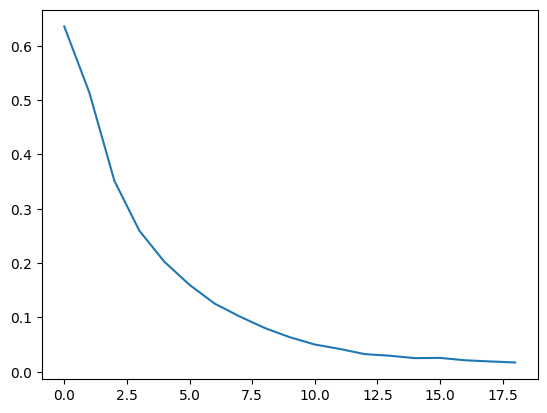

In [ ]:
plt.plot(train_losses)

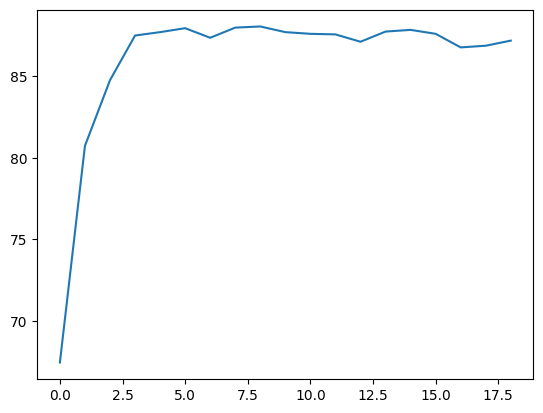

In [ ]:
plt.plot(eval_accuracies)